# Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).<br>
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.<br>
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.<br>
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

1. На какие метрики Вы смотрите в ходе анализа и почему?<br>
2. Имеются ли различия в показателях и с чем они могут быть связаны?<br>
3. Являются ли эти различия статистически значимыми?<br>
4. Стоит ли запускать новую механику на всех пользователей?

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import chi2_contingency

from tqdm.auto import tqdm

## Предварительный анализ и предобработка данных

In [2]:
# Скачаем датасет groups - информация о принадлежности пользователя к контрольной или целевой группе
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_groups}', sep=';')
print(groups.shape)
groups.head(3)

(74484, 2)


,id,grp
0,1489,B
1,1627,A
2,1768,B


In [3]:
# Проверка на пустые значения
groups.isna().sum()

# Пустых значений нет

id     0
grp    0
dtype: int64

In [4]:
# Типы данных
groups.dtypes

id      int64
grp    object
dtype: object

In [5]:
# Количество пользователей в группах
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [6]:
# Скачаем датасет groups_add - дополнительный файл с пользователями
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
groups_add = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_groups_add}')
print(groups_add.shape)
groups_add.head(3)

(92, 2)


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [7]:
# Проверка на пустые значения
groups_add.isna().sum()

# Пустых значений нет

id     0
grp    0
dtype: int64

In [8]:
# Типы данных
groups_add.dtypes

id      int64
grp    object
dtype: object

In [9]:
# Количество пользователей в группах
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [10]:
# Скачаем датасет active_studs - информация о пользователях, которые зашли на платформу в дни проведения эксперимента
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
active_studs = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_active_studs}')
print(active_studs.shape)
active_studs.head(3)

(8341, 1)


,student_id
0,581585
1,5723133
2,3276743


In [11]:
# Проверка на пустые значения
active_studs.isna().sum()

# Пустых значений нет

student_id    0
dtype: int64

In [12]:
# Типы данных
active_studs.dtypes

student_id    int64
dtype: object

In [13]:
# Скачаем датасет checks - информация об оплатах пользователей в дни проведения эксперимента
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
checks = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_checks}', sep=';')
print(checks.shape)
checks.head(3)

(541, 2)


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [14]:
# Проверка на пустые значения
checks.isna().sum()

# Пустых значений нет

student_id    0
rev           0
dtype: int64

In [15]:
# Типы данных
checks.dtypes

student_id      int64
rev           float64
dtype: object

#### Создаем объединенный датафрейм

Создадим groups_all, где конкатинируем датафреймы groups и groups_add<br>

In [16]:
groups_all = pd.concat([groups, groups_add], ignore_index=True).rename(columns={'id': 'student_id'})
print(groups_all.shape)
groups_all.head(3)

(74576, 2)


,student_id,grp
0,1489,B
1,1627,A
2,1768,B


In [17]:
# Проверка активных пользователей в общей информации
active_studs.query("student_id not in @groups_all.student_id").shape[0]

0

In [18]:
# Проверка оплативших пользователей в общей информации
checks.query("student_id not in @groups_all.student_id").shape[0]

0

In [19]:
# Проверка оплативших пользователей в активных пользователях
checks.query("student_id not in @active_studs.student_id").shape[0]

149

Получается, что у нас есть 149 пользователей, которые оплатили, но были не активны. 
Это могло произойти по причине сбоя и данные не попали в active_studs.
Либо у них возможно был установлен автоплатеж и они действительно не заходили на сайт. 
У нас нет возможности провести расследование поэтому оплативших и неактивных переводим в активных. Будем считать, что был сбой при заполнении active_studs. да и данных у нас не так много, чтобы ими разбрасываться :) 

In [20]:
active_checks = active_studs.merge(checks, how='outer', on='student_id')
active_checks.count()

student_id    8490
rev            541
dtype: int64

Создадим датафрейм, в который попадет информация о активных платящих пользователях с разбивкой по группам.

In [21]:
df = active_checks.merge(groups_all, how='left', on='student_id').fillna(0).rename(columns={'rev': 'Revenue'})
print(df.shape)
df.head(3)

(8490, 3)


,student_id,Revenue,grp
0,581585,0.0,A
1,5723133,0.0,A
2,3276743,0.0,B


### 1. На какие метрики Вы смотрите в ходе анализа и почему?

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. К сожалению, нет расшифровки, что значит новая механика оплата услуг. Можно предполагать что угодно связанное именно с оплатой. Как правило, любое улучшение направлено на получение либо прибыли, либо еще какой-то денежной составляющей. В нашем случае будем рассматривать метрику CR - конверсия активных (посетивших сайт) пользователей в покупку. Также рассмотрим ARPAU (средний платеж на всех активных пользователей) и ARPPU (средний платеж на всех платящих пользователей, более точный чем ARPAU, можно назвать средний чек). ARPU не рассматривается - потому что у нас есть распределение пользователей по группам, но не указано это все пользователи или нет.

In [22]:
# Добавляем флаг оплаты
df['flag_pay'] = np.where(df['Revenue'] > 0, 1, 0)

In [23]:
# сгруппируем данные по группам. 
df_gr = df.groupby('grp', as_index=False).agg(SumRevenue=('Revenue', 'sum'), CountPay=('flag_pay', 'sum'),
                                              CountActive=('student_id', 'count'))

# SumRevenue - сумма по доходу, CountPay - количество оплативших, CountActive - количество активных
df_gr

,grp,SumRevenue,CountPay,CountActive
0,A,92096.0000,107,1567
1,B,481230.0036,434,6923


In [24]:
# расчитаем метрики
df_gr['ARPPU'] = (df_gr['SumRevenue'] / df_gr['CountPay']).round(1)
df_gr['ARPAU'] = (df_gr['SumRevenue'] / df_gr['CountActive']).round(1)
df_gr['CR'] = (df_gr['CountPay'] / df_gr['CountActive'] * 100).round(3)
df_gr

,grp,SumRevenue,CountPay,CountActive,ARPPU,ARPAU,CR
0,A,92096.0000,107,1567,860.7,58.8,6.828
1,B,481230.0036,434,6923,1108.8,69.5,6.269


In [25]:
# Получим серии с разбивкой по группам и по оплате (для ARPPU)
df_ARPPU_A = df.query('flag_pay==1 and grp=="A"')['Revenue']
df_ARPPU_B = df.query('flag_pay==1 and grp=="B"')['Revenue']
df_ARPAU_A = df.query('grp=="A"')['Revenue']
df_ARPAU_B = df.query('grp=="B"')['Revenue']

Визуализируем распределение данных

Text(0.5, 1.0, 'ARPPU группа А')

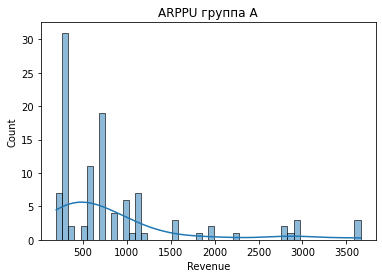

In [26]:
sns.histplot(df_ARPPU_A, bins=50, kde=True).set_title("ARPPU группа А")

Text(0.5, 1.0, 'ARPPU группа B')

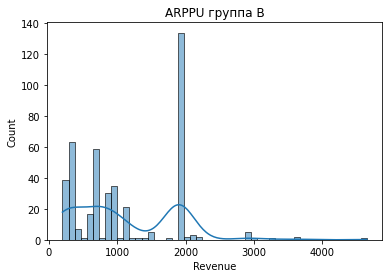

In [27]:
sns.histplot(df_ARPPU_B, bins=50, kde=True).set_title("ARPPU группа B")

Text(0.5, 1.0, 'ARPAU группа А')

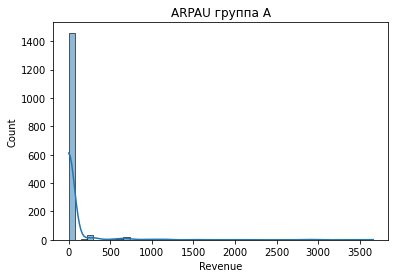

In [28]:
sns.histplot(df_ARPAU_A, bins=50, kde=True).set_title("ARPAU группа А")

Text(0.5, 1.0, 'ARPAU группа B')

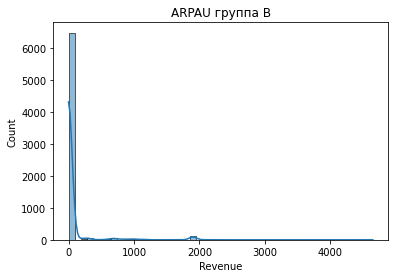

In [29]:
sns.histplot(df_ARPAU_B, bins=50, kde=True).set_title("ARPAU группа B")

Тесты для проверки нормальности распределения

In [30]:
shapiro(df_ARPPU_A)

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)

In [31]:
shapiro(df_ARPPU_B)

ShapiroResult(statistic=0.8672363758087158, pvalue=8.947892893418603e-19)

In [32]:
shapiro(df_ARPAU_A)

ShapiroResult(statistic=0.1949470043182373, pvalue=0.0)

In [33]:
shapiro(df_ARPAU_B)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.22011637687683105, pvalue=0.0)

И визуализация распределения данных и тесты для проверки нормальности - все говорит что распределение отклоняется от нормального.

In [34]:
# на графике "ARPPU группа B" заметен скачок в районе 1900. 
# на графике "ARPAU группа B" тоже видно, но не настолько выражено. 
# разберемся что за скачок - сделаем группировку по суммам
df.query('flag_pay==1 and grp=="B"').Revenue.value_counts(normalize=True).head(10)
# получается, что более 30% приходится на сумму 1900

1900.0000    0.223502
290.0000     0.145161
690.0000     0.135945
199.0000     0.089862
1900.0001    0.082949
990.0000     0.080645
840.0000     0.055300
1140.0000    0.046083
580.0000     0.020737
398.0000     0.016129
Name: Revenue, dtype: float64

In [35]:
df.query('flag_pay==1 and grp=="A"').Revenue.value_counts(normalize=True).head(10)

290.0     0.289720
690.0     0.177570
199.0     0.065421
580.0     0.056075
990.0     0.056075
1140.0    0.046729
590.0     0.046729
1530.0    0.028037
3660.0    0.028037
840.0     0.028037
Name: Revenue, dtype: float64

### 2. Имеются ли различия в показателях и с чем они могут быть связаны?

Контрольная группа - группа А, оставалась базовая механика оплаты. Целевая группа - группа B, предложена новая механика оплаты услуг на сайте.<br>
ARPPU выше у целевой группы, также выше и ARPAU (но не так четко выражена). Далее будем рассматривать ARPPU, чтобы не повторяться.<br>
Из визуализации видно (а также из распределения оплат), что в целевой группе около 31% приходится на сумму 1900.<br>
В контрольной группе такого не наблюдается. Возможно тут сказалась новая механика оплаты. Но меня очень смущает сама сумма в 1900.<br>
Возможно следующее: в период проведения теста была проведена какая-то акция на покупку блоков курсов. Или была проведена подписка на курсы на какой-то срок.<br>
Также очень смущает перекос в количестве в целевой группе относительно контрольной более чем в 4 раза. Возможно пользователям целевой группы были предложены заранее какие-то "пряники" в виде покупки чего-то за 1900.<br>
Все говорит об одном - подготовка и проведение A/B теста выполнено очень некорректно. Если бы это было в проде то тест анулировался бы.
Но для учебных целей продолжим :)<br>
Если говорить про CR, то он ниже в целевой группе. Это пока не говорит о статистически значимом различии. Возможно новая механика и приводит к уменьшению конверсии в покупку.

### 3. Являются ли эти различия статистически значимыми?

Рассмотрим следующие гипотезы:<br>
ARPPU:<br>
    H0-ARPPU: изменение механики оплат не приводит к изменению ARPPU<br>
    H1-ARPPU: изменение механики оплат приводит к изменению ARPPU<br>
ARPAU:<br>
    H0-ARPAU: изменение механики оплат не приводит к изменению ARPAU<br>
    H1-ARPAU: изменение механики оплат приводит к изменению ARPAU<br>
CR:<br>
    H0-CR: изменение механики оплат не приводит к изменению CR<br>
    H1-CR: изменение механики оплат приводит к изменению CR<br>

#### Гипотеза о ARPPU

Как было ранее уже сказано - распределение отклоняется от нормального. Размер выборки отличается друг от друга. Сам размер выборки небольшой. Вбросов с максимальными оплатами нет. Все указывает на бутстрап по среднему.

In [36]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

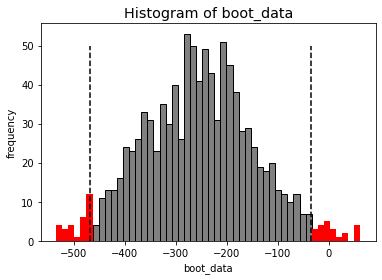

In [37]:
# Бутстрап 
booted_data = get_bootstrap(df_ARPPU_A, df_ARPPU_B)

In [38]:
booted_data["p_value"] 

0.01837598707611996

In [39]:
booted_data["quants"]

,0
0.025,-467.594402
0.975,-35.296739


Применение теста бутстрап для проверки H0-ARPPU получилось p_value<0.05. Отвергаем H0-ARPPU.
Обе границы меньше 0, более предпочтителен вариант А - контрольная группа. Наше предположение что ARPPU вырос опровергнуто.

#### Гипотеза о ARPAU

Аналогично рассмотрим ARPAU.

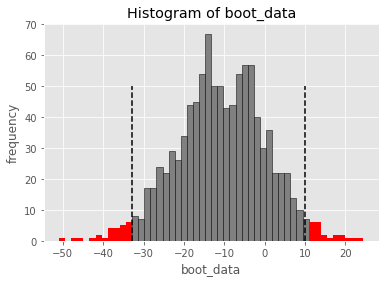

In [40]:
# Бутстрап 
booted_data = get_bootstrap(df_ARPAU_A, df_ARPAU_B)

In [41]:
booted_data["p_value"] 

0.3282653303626273

In [42]:
booted_data["quants"]

,0
0.025,-32.861823
0.975,10.076356


Бутрсап показывает, что p_value>0.05. А значит подтверждается правильность гипотезы H0-ARPAU.

#### Гипотеза об CR

Для проверки статистическйо значимости различий в показателе CR применяется метод Хи-квадрат

In [43]:
# Создадим таблицу сопряженности
t_sopr = np.array([[df_gr.query('grp=="A"').CountActive, df_gr.query('grp=="A"').CountPay],
                   [df_gr.query('grp=="B"').CountActive, df_gr.query('grp=="B"').CountPay]])
# Применим метод Хи-квадрат
statistic, pvalue, dof, expected_freq = chi2_contingency(t_sopr)

# Выведем p-value
print(f"p-value: {pvalue}")

p-value: 0.4778925970224768


Метод Хи-квадрат показал p_value>0.05. А значит подтверждается правильность гипотезы H0-CR.

### 4. Стоит ли запускать новую механику на всех пользователей?

В результате анализа было выявлено, что новый механизм оплаты не приводит к изменению показателя CR, ARPAU и приводит к уменьшению показателя ARPPU.<br>
Кроме того, при проведении эксперимента наблюдались следующие аномалии:<br> 1. 149 пользователей, которые оплатили, но были не активны.<br> 2. 31% в целевой группе сделали покупки на сумму 1900.<br>
Все это говорит о сбое в работе эксперимента. <br>
Считаю, что не стоит запускать новую механику на всех пользователей (согласно нашим метрикам). Либо устранить замечания в системе и повторить эксперимент.<br>
В качестве юмора: есть подозрение, что в лоббировании внедрение нового механизма оплаты есть сильная зависимость от HiPPO.:)
